<a href="https://colab.research.google.com/github/nafizfouad/Predicting_Product_Launch_Success_Using_Sentiment_Analysis/blob/main/PPLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/dataset/amazon_electronics.csv')

Mounted at /content/drive


In [ ]:
# Code for Sentimental Analysis

# Start

# adding a sentiment column to classify reviews as Positive or Negative
# Positive = 1
# Negative = 0

# Define a function to check the conditions and assign sentiment accordingly
import numpy as np

# Assuming your dataset is named 'data'

# Define a function to check the conditions and assign sentiment accordingly
def assign_sentiment(row):
    if row['total_votes'] > 0:
        if row['vine'] == 'Y':
            if row['star_rating'] == 5 and row['helpful_votes'] / row['total_votes'] >= 0.8:
                return 1
            else:
                return 0
        else:
            if row['star_rating'] >= 4 and row['helpful_votes'] / row['total_votes'] >= 0.5:
                return 1
            elif row['star_rating'] >= 4 and row['helpful_votes'] / row['total_votes'] < 0.5:
                return 0
            elif row['star_rating'] < 4 and row['helpful_votes'] / row['total_votes'] < 0.5:
                return 1
            else:
                return 0
    else:
        if row['vine'] == 'Y' and row['star_rating'] == 5:
            return 1
        elif row['star_rating'] >= 4:
            return 1
        else:
            return 0

# Apply the function to create the 'sentiment' column
data['sentiment'] = data.apply(assign_sentiment, axis=1)

# get unique values of product title column
data["product_title"].unique()


array(['yoomall 5M Antenna WIFI RP-SMA Female to Male Extensionl Cable',
       'Hosa GPM-103 3.5mm TRS to 1/4" TRS Adaptor',
       'Channel Master Titan 2 Antenna Preamplifier', ...,
       'Removable Car Stereo Faceplate Case (Discontinued by Manufacturer)',
       'Interact 62057 CD Jewel Box Replacement Cases (10-Pack)',
       'JVC RX-668 Audio/Video Receiver'], dtype=object)

In [ ]:
#finding the best product to work with
product_occurrences = data['product_title'].value_counts()

popular_products = product_occurrences[product_occurrences >= 10000].index.tolist()

differences = {}
for product in popular_products:
    ratings_leq_3 = data[(data['product_title'] == product) & (data['star_rating'] <= 3)].shape[0]
    ratings_gt_3 = data[(data['product_title'] == product) & (data['star_rating'] > 3)].shape[0]
    difference = abs(ratings_leq_3 - ratings_gt_3)
    differences[product] = difference

least_diff_product = min(differences, key=differences.get)
least_diff_value = differences[least_diff_product]

print("Product with at least 20,000 occurrences and least difference in ratings <=3 and >3:")
print("Product Title:", least_diff_product)
print("Difference:", least_diff_value)

Product with at least 20,000 occurrences and least difference in ratings <=3 and >3:
Product Title: Clip Plus 4 GB MP3 Player (Black)
Difference: 4509


In [ ]:
prod_hosa = data.loc[data["product_title"]=='Clip Plus 4 GB MP3 Player (Black)']
prod_hosa

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,sentiment
283,US,46440750,R3SX2T4X6GHSL0,B002MAPT7U,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,1,0,0,N,Y,JUNK,"died on me only after a year of use, ridiculou...",0
891,US,1151466,R18FOJC1YZFKEU,B00400TGEC,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,5,0,0,N,Y,sound,Quality!! And has a powerful sound!!,1
1689,US,31463514,R3C291ENL4JOLF,B002MAPS6W,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,3,0,0,N,Y,I like how it can easily change to next song a...,I like how it can easily change to next song a...,0
3400,US,51584798,R3U4XKI2EIOYFR,B002MAPT7U,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,5,0,0,N,Y,Bought as a gift... no complaints from ...,Bought as a gift...no complaints from recipien...,1
3533,US,4761986,R3N1OJLWXWNI2F,B002MAPT7U,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,5,0,0,N,Y,Five Stars,My son loves this.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808206,US,50575556,R3G3AS1L13Q20Z,B002MAPRYU,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,3,9,9,N,Y,"Great sound, problems loading up",I was so excited to get this Clip Plus. I had ...,0
2808301,US,44591774,R2GLCVFEZF0XP2,B002MAPSC6,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,5,89,89,N,Y,Great MP3 Player!,9/14/2009: This is my first MP3 player. I'...,1
2809351,US,30608005,RC6F44Z6OH682,B002MAPRYU,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,2,131,131,N,Y,Buggy for a 2nd generation product,The Clip+ is the ideal size for runners or gym...,0
2810545,US,52647835,R1EZSABH5XJNSV,B002MAPT7U,808084969,Clip Plus 4 GB MP3 Player (Black),Electronics,5,1390,1390,N,N,Great upgrade to an already great budget player,If all you are looking for is a great sounding...,1


In [ ]:
# #split data-set to train and test

X = prod_hosa['review_body']
Y = prod_hosa['sentiment']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [ ]:
# function to remove html elements from the reviews
def removeHTML(raw_text):
    clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text()
    return clean_HTML

In [ ]:
# function to remove special characters and numbers from the reviews4961
def removeSpecialChar(raw_text):
    clean_SpecialChar = re.sub("[^a-zA-Z]", " ", raw_text)
    return clean_SpecialChar

In [ ]:
# function to convert all reviews into lower case
def toLowerCase(raw_text):
    clean_LowerCase = raw_text.lower().split()
    return( " ".join(clean_LowerCase))

In [ ]:
# function to remove stop words from the reviews
def removeStopWords(raw_text):
    stops = set(stopwords.words("english"))
    words = [w for w in raw_text if not w in stops]
    return( " ".join(words))

In [ ]:
# X_training clean set
nltk.download('stopwords')
X_train_cleaned = []

for val in X_train:
    val = removeHTML(val)
    val = removeSpecialChar(val)
    val = toLowerCase(val)
    removeStopWords(val)
    X_train_cleaned.append(val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-60-c2a805237a43>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text()


In [ ]:
# X_testing clean set
X_test_cleaned = []

for val in X_test:
    val = removeHTML(val)
    val = removeSpecialChar(val)
    val = toLowerCase(val)
    removeStopWords(val)
    X_test_cleaned.append(val)

<ipython-input-60-c2a805237a43>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_HTML = BeautifulSoup(raw_text, 'lxml').get_text()


In [ ]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
tvec = TfidfVectorizer(use_idf=True,
strip_accents='ascii')

X_train_tvec = tvec.fit_transform(X_train_cleaned)

In [ ]:
# Define the Support Vector Classifier model
svr_lin = LinearSVC(multi_class='ovr', C=1.0, loss='squared_hinge', dual=False)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(svr_lin, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())

4-Fold Cross-Validation Results:
   Accuracy  Precision    Recall  F1 Score
1  0.882003   0.868685  0.853936  0.860664
2  0.890917   0.876383  0.860926  0.868038
3  0.889219   0.877933  0.855259  0.865288
4  0.887473   0.875422  0.862278  0.868328

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.8874031699342873
Mean Precision: 0.8746055863043681
Mean Recall: 0.8580996044421434
Mean F1 Score: 0.865579697801547

10-Fold Cross-Validation Results:
    Accuracy  Precision    Recall  F1 Score
1   0.891835   0.873805  0.869338  0.871516
2   0.880170   0.865174  0.854933  0.859726
3   0.883351   0.866908  0.851421  0.858529
4   0.895966   0.881770  0.876136  0.878858
5   0.890658   0.880255  0.857129  0.867331
6   0.889597   0.886416  0.862084  0.872379
7   0.897028   0.878288  0.855845  0.866051
8   0.898089   0.890699  0.866739  0.877267
9   0.889597   0.875465  0.863713  0.869198
10  0.880042   0.867194  0.859094  0.862911

Mean Scores for 10-Fold Cross-Validation:
Mean Accuracy:

In [ ]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers
svr_lin.fit(X_train_tvec, Y_train)
svr_lin_predictions = svr_lin.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,svr_lin_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = sns.light_palette("yellow", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.843700,0.804500,0.823600,711.000000
1,0.917200,0.935600,0.926300,1645.000000
accuracy,0.896000,0.896000,0.896000,0.896000
macro avg,0.880400,0.870000,0.874900,2356.000000
weighted avg,0.895000,0.896000,0.895300,2356.000000


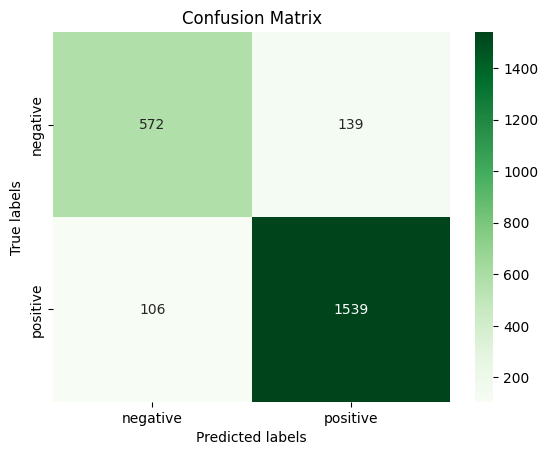

In [ ]:
# confusion matrix
svr_lin_predictions=svr_lin.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,svr_lin_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [ ]:
# testing the model with sample 'Negative' review
demo_review = np.array(['three days of use and it broke very disappointed in this product it worked perfectly for exactly three days and could not be resuscitated it was very inexpensive so i did not want to pay half again the price to ship it back for an exchange so the company would do nothing when they sent me an inquiry as to product satisfaction'])
demo_review_X_test = tvec.transform(demo_review)
print(svr_lin.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [ ]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Excellent product. Works well and performs as expected.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(svr_lin.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [ ]:
# Random Forest model
random_forest = RandomForestClassifier(n_estimators=20,random_state=42)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(random_forest, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())


4-Fold Cross-Validation Results:
   Accuracy  Precision    Recall  F1 Score
1  0.846774   0.849209  0.785740  0.806675
2  0.849745   0.845930  0.785244  0.806279
3  0.846350   0.850304  0.775412  0.799162
4  0.846709   0.849072  0.788565  0.808676

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.847394599865186
Mean Precision: 0.8486284435641696
Mean Recall: 0.7837401090313723
Mean F1 Score: 0.8051978606629093

10-Fold Cross-Validation Results:
    Accuracy  Precision    Recall  F1 Score
1   0.853659   0.844036  0.798780  0.815914
2   0.818664   0.813704  0.750776  0.769932
3   0.846235   0.835218  0.785794  0.803937
4   0.855626   0.863703  0.795250  0.817625
5   0.846072   0.835461  0.789070  0.806265
6   0.840764   0.851006  0.785381  0.805308
7   0.855626   0.847113  0.771103  0.797075
8   0.851380   0.852707  0.789510  0.810862
9   0.841826   0.851234  0.770072  0.794243
10  0.836518   0.836650  0.783394  0.800993

Mean Scores for 10-Fold Cross-Validation:
Mean Accuracy:

In [ ]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers
random_forest.fit(X_train_tvec, Y_train)
ranfrst_predictions = random_forest.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,ranfrst_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = sns.light_palette("red", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.844400,0.663900,0.743300,711.000000
1,0.867000,0.947100,0.905300,1645.000000
accuracy,0.861600,0.861600,0.861600,0.861600
macro avg,0.855700,0.805500,0.824300,2356.000000
weighted avg,0.860200,0.861600,0.856400,2356.000000


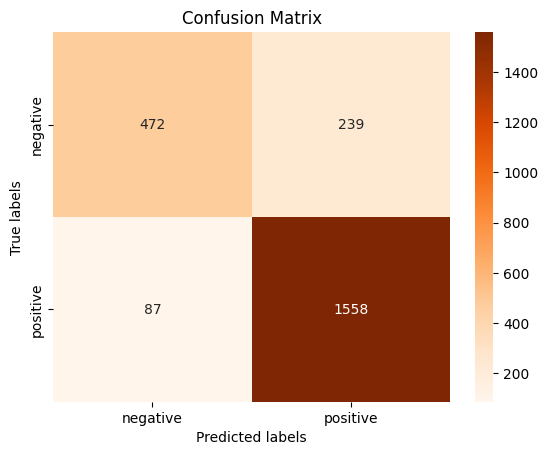

In [ ]:
# confusion matrix
ranfrst_predictions=random_forest.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,ranfrst_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Oranges');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [ ]:
# testing the model with sample 'Negative' review
demo_review = np.array(['Do not buy. Fake Product.'])
demo_review_X_test = tvec.transform(demo_review)
print(random_forest.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [ ]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Original Product. Great Performance.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(random_forest.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [ ]:
# Define the Logistic Regression model
logistic_classifier = LogisticRegression(random_state=42)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results for Logistic Regression Classifier:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(logistic_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results for Logistic Regression Classifier:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())


4-Fold Cross-Validation Results for Logistic Regression Classifier:
   Accuracy  Precision    Recall  F1 Score
1  0.875637   0.870820  0.834404  0.849034
2  0.891766   0.889630  0.847999  0.864876
3  0.888795   0.892553  0.839655  0.859897
4  0.878132   0.876173  0.837414  0.852734

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.883582144698092
Mean Precision: 0.8822940731685639
Mean Recall: 0.8398678334338834
Mean F1 Score: 0.8566351448717892

10-Fold Cross-Validation Results for Logistic Regression Classifier:
    Accuracy  Precision    Recall  F1 Score
1   0.888653   0.879904  0.851372  0.863622
2   0.869565   0.868611  0.822981  0.840243
3   0.871686   0.861553  0.825042  0.839934
4   0.902335   0.903337  0.867272  0.882132
5   0.888535   0.885626  0.845884  0.862011
6   0.882166   0.889434  0.843172  0.860255
7   0.897028   0.891078  0.841153  0.861520
8   0.891720   0.898937  0.844204  0.864854
9   0.888535   0.886459  0.847965  0.863564
10  0.883227   0.879538  0.8516

In [ ]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tvec, Y_train)
lr_predictions = lr.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,lr_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = sns.light_palette("purple", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.876200,0.766500,0.817700,711.000000
1,0.904300,0.953200,0.928100,1645.000000
accuracy,0.896900,0.896900,0.896900,0.896900
macro avg,0.890200,0.859900,0.872900,2356.000000
weighted avg,0.895800,0.896900,0.894800,2356.000000


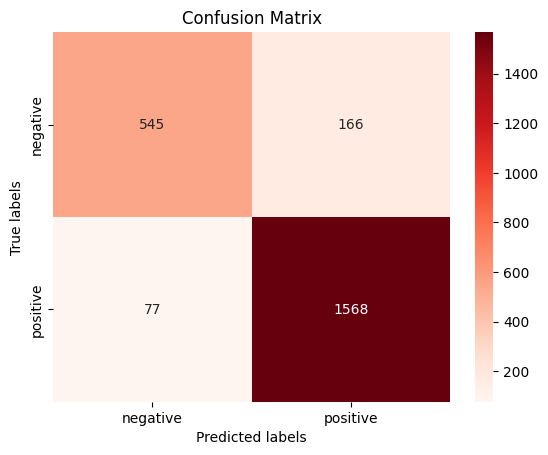

In [ ]:
# confusion matrix
lr_predictions=lr.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,lr_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Reds');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [ ]:
# testing the model with sample 'Negative' review
demo_review = np.array(['Poor quality. Faulty device.'])
demo_review_X_test = tvec.transform(demo_review)
print(lr.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [ ]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Best product.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(lr.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Define the Multinomial Naive Bayes classifier model
nb_classifier = MultinomialNB()

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4 = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4 = pd.DataFrame(index=range(1, 5))
cv_results_4['Accuracy'] = cv_scores_4
cv_results_4['Precision'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4['Recall'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4['F1 Score'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:")
print(cv_results_4)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_4.mean())
print("Mean Precision:", cv_results_4['Precision'].mean())
print("Mean Recall:", cv_results_4['Recall'].mean())
print("Mean F1 Score:", cv_results_4['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10 = pd.DataFrame(index=range(1, 11))
cv_results_10['Accuracy'] = cv_scores_10
cv_results_10['Precision'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10['Recall'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10['F1 Score'] = cross_val_score(nb_classifier, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:")
print(cv_results_10)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation:")
print("Mean Accuracy:", cv_scores_10.mean())
print("Mean Precision:", cv_results_10['Precision'].mean())
print("Mean Recall:", cv_results_10['Recall'].mean())
print("Mean F1 Score:", cv_results_10['F1 Score'].mean())

4-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:
   Accuracy  Precision    Recall  F1 Score
1  0.774618   0.843646  0.648835  0.660234
2  0.789898   0.857502  0.657961  0.675467
3  0.784380   0.866865  0.648492  0.662449
4  0.769002   0.847045  0.642887  0.651098

Mean Scores for 4-Fold Cross-Validation:
Mean Accuracy: 0.7794746394443063
Mean Precision: 0.8537644639421593
Mean Recall: 0.6495438121214783
Mean F1 Score: 0.6623119735632733

10-Fold Cross-Validation Results for Multinomial Naive Bayes Classifier:
    Accuracy  Precision    Recall  F1 Score
1   0.806999   0.867821  0.688807  0.713349
2   0.775186   0.825754  0.656235  0.669648
3   0.797455   0.869153  0.667740  0.688324
4   0.809979   0.867380  0.705975  0.730747
5   0.785563   0.845308  0.657078  0.673422
6   0.787686   0.871229  0.685111  0.701581
7   0.808917   0.864036  0.655783  0.679931
8   0.801486   0.883950  0.680738  0.702701
9   0.796178   0.854297  0.679843  0.700725
10  0.772824   0.83362

In [ ]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers
nbm = MultinomialNB()
nbm.fit(X_train_tvec, Y_train)
nbm_predictions = nbm.predict(tvec.transform(X_test_cleaned))
report = classification_report(Y_test,nbm_predictions, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(4)
cm = sns.light_palette("blue", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.935400,0.386800,0.547300,711.000000
1,0.788600,0.988400,0.877300,1645.000000
accuracy,0.806900,0.806900,0.806900,0.806900
macro avg,0.862000,0.687600,0.712300,2356.000000
weighted avg,0.832900,0.806900,0.777700,2356.000000


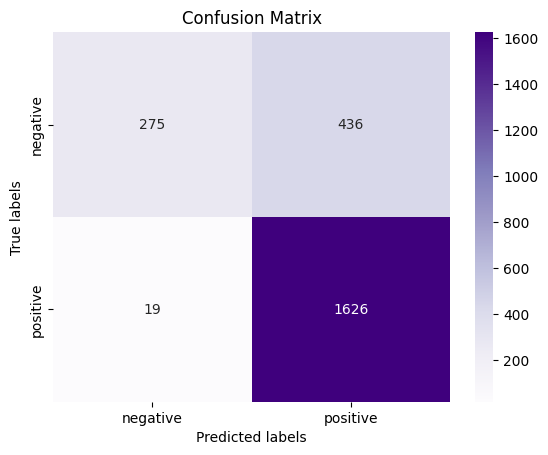

In [ ]:
# confusion matrix
nbm_predictions=nbm.predict(tvec.transform(X_test_cleaned))
ax= plt.subplot()
cm=confusion_matrix(Y_test,nbm_predictions)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Purples');
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

In [ ]:
# testing the model with sample 'Negative' review
demo_review = np.array(['Defective. Bad. Stopped working after one day use'])
demo_review_X_test = tvec.transform(demo_review)
print(nbm.predict(demo_review_X_test))

# expected output = 0 (Negative)
# actual output = 0 (Negative)

[0]


In [ ]:
# testing the model with sample 'Positive' review
demo_review_2 = np.array(['Good product. highly recommend buying.'])
demo_review_X_test_2 = tvec.transform(demo_review_2)
print(nbm.predict(demo_review_X_test_2))

# expected output = 1 (Positive)
# actual output = 1 (Positive)

[1]


In [95]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Perform 4-fold cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores_4_xgb = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_4_xgb = pd.DataFrame(index=range(1, 5))
cv_results_4_xgb['Accuracy'] = cv_scores_4_xgb
cv_results_4_xgb['Precision'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='precision_macro')
cv_results_4_xgb['Recall'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='recall_macro')
cv_results_4_xgb['F1 Score'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_4, scoring='f1_macro')

# Print 4-fold cross-validation results
print("4-Fold Cross-Validation Results (XGBoost):")
print(cv_results_4_xgb)

# Calculate and print mean scores for 4-fold cross-validation
print("\nMean Scores for 4-Fold Cross-Validation (XGBoost):")
print("Mean Accuracy:", cv_scores_4_xgb.mean())
print("Mean Precision:", cv_results_4_xgb['Precision'].mean())
print("Mean Recall:", cv_results_4_xgb['Recall'].mean())
print("Mean F1 Score:", cv_results_4_xgb['F1 Score'].mean())

# Perform 10-fold cross-validation
kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10_xgb = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='accuracy')

# Create a DataFrame to store cross-validation results
cv_results_10_xgb = pd.DataFrame(index=range(1, 11))
cv_results_10_xgb['Accuracy'] = cv_scores_10_xgb
cv_results_10_xgb['Precision'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='precision_macro')
cv_results_10_xgb['Recall'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='recall_macro')
cv_results_10_xgb['F1 Score'] = cross_val_score(xgb_model, X_train_tvec, Y_train, cv=kf_10, scoring='f1_macro')

# Print 10-fold cross-validation results
print("\n10-Fold Cross-Validation Results (XGBoost):")
print(cv_results_10_xgb)

# Calculate and print mean scores for 10-fold cross-validation
print("\nMean Scores for 10-Fold Cross-Validation (XGBoost):")
print("Mean Accuracy:", cv_scores_10_xgb.mean())
print("Mean Precision:", cv_results_10_xgb['Precision'].mean())
print("Mean Recall:", cv_results_10_xgb['Recall'].mean())
print("Mean F1 Score:", cv_results_10_xgb['F1 Score'].mean())


4-Fold Cross-Validation Results (XGBoost):
   Accuracy  Precision    Recall  F1 Score
1  0.858234   0.847407  0.815525  0.828427
2  0.880306   0.870203  0.838991  0.852159
3  0.873514   0.865683  0.827495  0.842903
4  0.873461   0.867577  0.834689  0.848053

Mean Scores for 4-Fold Cross-Validation (XGBoost):
Mean Accuracy: 0.8713787628100454
Mean Precision: 0.8627173270735582
Mean Recall: 0.8291748743979933
Mean F1 Score: 0.8428854760801501

10-Fold Cross-Validation Results (XGBoost):
    Accuracy  Precision    Recall  F1 Score
1   0.890774   0.882612  0.853876  0.866220
2   0.843054   0.825889  0.802676  0.812436
3   0.863203   0.850344  0.814965  0.829351
4   0.878981   0.868938  0.845684  0.855754
5   0.878981   0.870795  0.837060  0.851036
6   0.870488   0.867914  0.835954  0.848625
7   0.875796   0.862524  0.811885  0.831992
8   0.880042   0.875264  0.837629  0.852841
9   0.873673   0.857688  0.842796  0.849580
10  0.856688   0.843907  0.826170  0.833887

Mean Scores for 10-Fold C

In [96]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_tvec, Y_train)
xgb_predictions = xgb_model.predict(tvec.transform(X_test_cleaned))
report_xgb = classification_report(Y_test, xgb_predictions, output_dict=True)
data_report_xgb = pd.DataFrame(report_xgb).transpose().round(4)
cm = sns.light_palette("blue", as_cmap=True)
styled_data_report_xgb = data_report_xgb.style.background_gradient(cmap=cm)
styled_data_report_xgb

,precision,recall,f1-score,support
0,0.838100,0.735600,0.783500,711.000000
1,0.891500,0.938600,0.914400,1645.000000
accuracy,0.877300,0.877300,0.877300,0.877300
macro avg,0.864800,0.837100,0.849000,2356.000000
weighted avg,0.875400,0.877300,0.874900,2356.000000


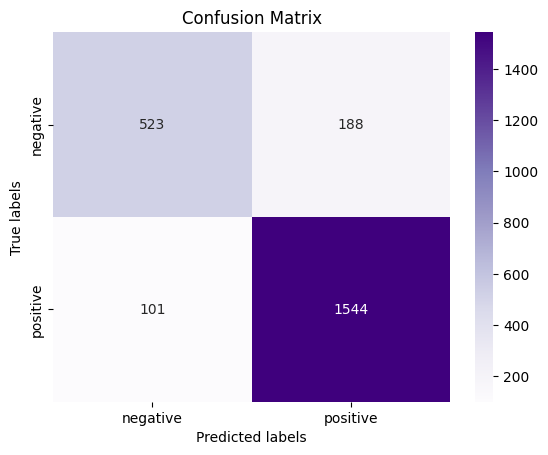

In [97]:
# conf mat
xgb_predictions = xgb_model.predict(tvec.transform(X_test_cleaned))
ax = plt.subplot()
cm_xgb = confusion_matrix(Y_test, xgb_predictions)
sns.heatmap(cm_xgb, annot=True, fmt='g', ax=ax, cmap='Purples')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['negative', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'positive'])
plt.show()